# Assignment 5: Deep Learning {-}

This assignment aims at familiarizing you with training and testing a Deep Neural Network (DNN). The dataset you will be working on is CIFAR-10. You will have to do:

1.  **(5 points) Coding tasks:** The following questions involve writing code to complete specific tasks.  
    1.1 *(1 point)* Load the CIFAR-10 dataset, visualize sample images, and perform data normalization to improve training performance.  
    1.2 *(1 point)* First network: Build, train, and test a deep neural network with at least three convolutional layers, two fully connected layers, and two pooling layers.  
    1.3 *(1 point)* Second network: Build, train, and test another deep neural network, with an architecture of your choice, but at most 4M (four million) parameters, ensuring the architecture meets this constraint by verifying with model.summary().  
    1.4 *(2 points)* Modify the second network architecture by tuning the layer hyperparameters or adjusting the layer design to improve test accuracy while remaining within the four million parameter limit. Discuss your observations and the trade offs of the changes you make.  

2.  **(5 points) Open discussion questions:** These discussion questions ask you to analyze and argue your points.  Feel free to include relevant code examples to strengthen your arguments.  
    2.1 *(1 point)* How did hyperparameter tuning (learning rate, dropout, batch size) affect your model’s accuracy? Were there any unexpected results?  
    2.2 *(1 point)* How did the constraint of keeping the model within 4 million parameters impact your design choices? Would a larger model necessarily perform better?  
    2.3 *(1 point)* How can deep learning models trained on datasets like CIFAR-10 be applied in real-world scenarios? Give an example.  
    2.4 *(1 point)* Deep learning models for image recognition can have biases. What ethical concerns should be considered when deploying such models?  
    2.5 *(1 point)* What was the most interesting or challenging part of this assignment? If you had more time, what additional improvements would you make?  

The dataset you will be working on is CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html) which consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. Here follows the ten object classes:
* airplane
*	automobile
*	bird
*	cat
*	deer
*	dog
*	frog
*	horse
*	ship
*	truck

Here follows some data samples in the dataset:

![alt text](https://docs.pytorch.org/tutorials/_images/cifar10.png)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment5-notebook.ipynb: Jupyter notebook containing source code.
- ./\<Test-accuracy>-\<StudentID>.txt: accuracy of the second network on the test set (for extra credit, see the 'Evaluation' part below). For example if you get 0.8124 accuracy, the name of this file is 08124-2012345.txt. The file content is left empty.

The submission folder is named ML4DS-\<StudentID>-Assignment5 (e.g., ML4DS-2012345-Assigment5) and then compressed with the same name.
    
### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. It is a plus if you have modeling steps other than the basic requirements and achieve an excellent model accuracy. In addition, your code should conform to a Python coding convention such as PEP-8.

EXTRA CREDIT: Top-3 submissions achieving the highest test accuracy on the second network (of 4M params at most) will be rewarded an extra credit. **You have to ensure the architecture meets this constraint by verifying and printing out the number of parameters with model.summary(). Please follow the submission format to be eligible for this extra credit.**

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras              # Keras is the high-level API of TensorFlow
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

2025-12-07 19:29:47.216783: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 19:29:47.283926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-12-07 19:29:48.937274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:

tf.config.set_visible_devices([], 'GPU')


W0000 00:00:1765110591.633937  507039 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765110591.641284  507039 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [3]:
# PLEASE DO NOT CHANGE THIS CODE

# Load the cifar10 dataset and split train/test
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Split train/valid from the training set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5)

y_train = y_train.reshape(-1,)
y_val = y_val.reshape(-1,)
y_test = y_test.reshape(-1,)


print("Train shape: X_train = " + str(X_train.shape) + ", y_train = " + str(y_train.shape))
print("Validation shape: X_val = " + str(X_val.shape) + ", y_val = " + str(y_val.shape))
print("Test shape: X_test = " + str(X_test.shape) + ", y_test = " + str(y_test.shape))

Train shape: X_train = (45000, 32, 32, 3), y_train = (45000,)
Validation shape: X_val = (5000, 32, 32, 3), y_val = (5000,)
Test shape: X_test = (10000, 32, 32, 3), y_test = (10000,)


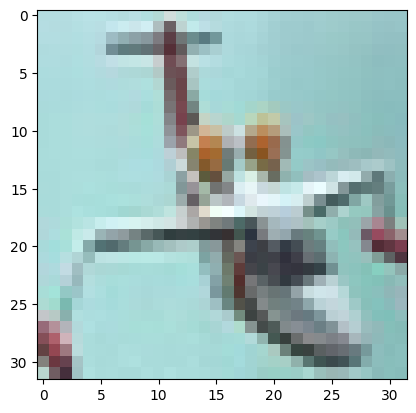

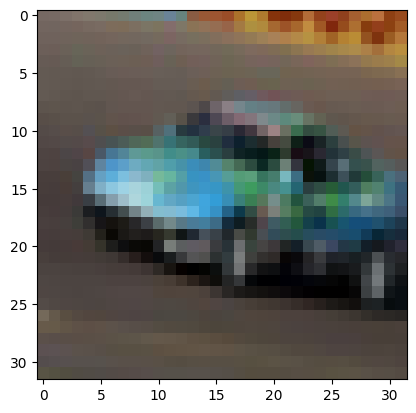

In [4]:
# Show some samples in the dataset
import matplotlib.pyplot as plt
imgplot = plt.imshow(X_train[44999])
plt.show()
imgplot = plt.imshow(X_test[4999])
plt.show()

## 1. Coding tasks

1. Load the CIFAR-10 dataset, visualize sample images, and perform data normalization to improve training performance.

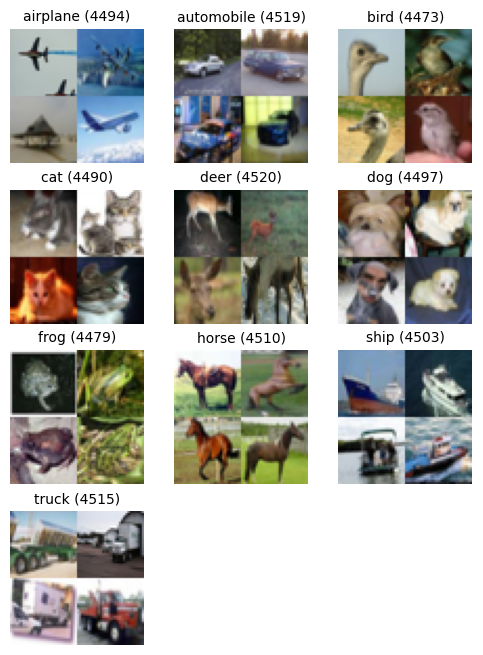

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Count how many samples belong to each class
class_counts = np.bincount(y_train.flatten(), minlength=10)

# For each class, collect indices of all images
class_indices = {i: np.where(y_train.flatten() == i)[0] for i in range(10)}

# Plot setup
fig, axes = plt.subplots(4, 3, figsize=(6, 8))
axes = axes.flatten()

for i in range(10):
    ax = axes[i]

    # Randomly pick 4 images from this class
    idxs = np.random.choice(class_indices[i], 4, replace=False)
    imgs = X_train[idxs]

    # Create a small 2x2 grid inside the subplot
    combined = np.zeros((64, 64, 3), dtype=np.uint8)  # 32*2 = 64 pixels per side
    combined[:32, :32] = imgs[0]
    combined[:32, 32:] = imgs[1]
    combined[32:, :32] = imgs[2]
    combined[32:, 32:] = imgs[3]

    ax.imshow(combined)
    ax.set_title(f"{class_names[i]} ({class_counts[i]})", fontsize=10)
    ax.axis("off")

# Turn off remaining unused subplots
for ax in axes[10:]:
    ax.axis("off")

plt.show()


In [6]:
# Convert pixel values from 0–255 to 0–1 (normalizing)
X_train_norm = X_train.astype("float32") / 255.0
X_val_norm = X_val.astype("float32") / 255.0
X_test_norm = X_test.astype("float32") / 255.0

print("Data normalized: pixel values are now between 0 and 1.")
print("Random normalized pixel: ", X_train_norm[44998][16][16])

Data normalized: pixel values are now between 0 and 1.
Random normalized pixel:  [0.09803922 0.07058824 0.0627451 ]


In [7]:
#training setup
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# Convert to tensors
X_train_t = torch.tensor(X_train_norm, dtype=torch.float32).permute(0, 3, 1, 2)
X_val_t   = torch.tensor(X_val_norm, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_t  = torch.tensor(X_test_norm, dtype=torch.float32).permute(0, 3, 1, 2)

y_train_t = torch.tensor(y_train.reshape(-1), dtype=torch.long)
y_val_t   = torch.tensor(y_val.reshape(-1), dtype=torch.long)
y_test_t  = torch.tensor(y_test.reshape(-1), dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=128)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128)

Training on: cuda:1


2. First network: Build, train, and test a deep neural network with at least three convolutional layers, two fully connected layers, and two pooling layers

In [8]:
# -------------------------
# Model
# -------------------------
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.2)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

model = MyCNN().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# -------------------------
# Train + Evaluate
# -------------------------
train_losses = []
val_accuracies = []

def train_one_epoch():
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    return correct / total


# -------------------------
# Run training
# -------------------------
for epoch in range(1, 31):
    train_loss = train_one_epoch()
    val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:2d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

# -------------------------
# Test accuracy
# -------------------------
test_acc = evaluate(test_loader)
print("Test accuracy:", test_acc)


MyCNN(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): D

Epoch  1 | Loss: 1.5108 | Val Acc: 0.5998


Epoch  2 | Loss: 1.1127 | Val Acc: 0.6470


Epoch  3 | Loss: 0.9519 | Val Acc: 0.7044


Epoch  4 | Loss: 0.8345 | Val Acc: 0.7450


Epoch  5 | Loss: 0.7423 | Val Acc: 0.7802


Epoch  6 | Loss: 0.6769 | Val Acc: 0.7938


Epoch  7 | Loss: 0.6253 | Val Acc: 0.8012


Epoch  8 | Loss: 0.5798 | Val Acc: 0.8106


Epoch  9 | Loss: 0.5414 | Val Acc: 0.8136


Epoch 10 | Loss: 0.5090 | Val Acc: 0.8374


Epoch 11 | Loss: 0.4741 | Val Acc: 0.8322


Epoch 12 | Loss: 0.4575 | Val Acc: 0.8408


Epoch 13 | Loss: 0.4328 | Val Acc: 0.8422


Epoch 14 | Loss: 0.4119 | Val Acc: 0.8366


Epoch 15 | Loss: 0.3933 | Val Acc: 0.8502


Epoch 16 | Loss: 0.3716 | Val Acc: 0.8542


Epoch 17 | Loss: 0.3624 | Val Acc: 0.8550


Epoch 18 | Loss: 0.3359 | Val Acc: 0.8612


Epoch 19 | Loss: 0.3257 | Val Acc: 0.8566


Epoch 20 | Loss: 0.3136 | Val Acc: 0.8584


Epoch 21 | Loss: 0.2962 | Val Acc: 0.8604


Epoch 22 | Loss: 0.2884 | Val Acc: 0.8592


Epoch 23 | Loss: 0.2734 | Val Acc: 0.8628


Epoch 24 | Loss: 0.2664 | Val Acc: 0.8662


Epoch 25 | Loss: 0.2594 | Val Acc: 0.8640


Epoch 26 | Loss: 0.2473 | Val Acc: 0.8632


Epoch 27 | Loss: 0.2376 | Val Acc: 0.8618


Epoch 28 | Loss: 0.2288 | Val Acc: 0.8666


Epoch 29 | Loss: 0.2210 | Val Acc: 0.8652


Epoch 30 | Loss: 0.2230 | Val Acc: 0.8680


Test accuracy: 0.8744


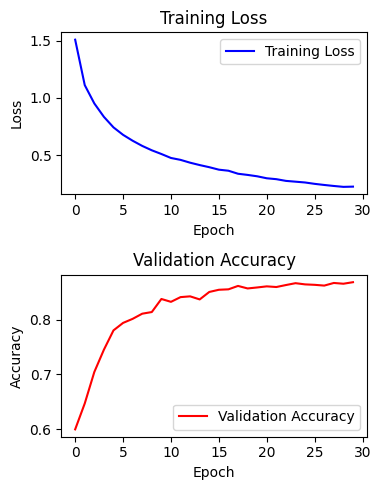

In [9]:
# Visualize training and validation performance
f, ax = plt.subplots(2, 1, figsize=(4, 5))

# Plot training loss
ax[0].plot(train_losses, color='b', label='Training Loss')
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot validation accuracy
ax[1].plot(val_accuracies, color='r', label='Validation Accuracy')
ax[1].set_title("Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()


3. Second network: Build, train, and test another deep neural network, with an architecture of your choice, but at most 4M (four million) parameters, ensuring the architecture meets this constraint by verifying with model.summary().

In [ ]:
# -------------------------
# My model resnet
# -------------------------
import torch.nn.functional as F
import torch.nn as nn
import torch

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(x)


class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, dropout=0.05):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),

            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
        )

        self.shortcut = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()
        self.se = SEBlock(out_c)

    def forward(self, x):
        out = self.conv(x)
        out = self.se(out)
        return F.relu(out + self.shortcut(x))


class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # keep original width
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResBlock(64, 128),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            ResBlock(128, 256),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            ResBlock(256, 278),
            nn.MaxPool2d(2)
        )

        self.layer4 = nn.Sequential(
            ResBlock(278, 278)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(278, 10)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


model = BetterCNN().to(device)


In [11]:
# -------------------------
# Count Trainable Parameters
# -------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params = count_params(model)
print(f"\nTotal Trainable Parameters: {params:,}")



Total Trainable Parameters: 3,986,382


In [12]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# CIFAR-10 normalization constants
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

# -------------------------
# Training Transformations
# -------------------------
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomGrayscale(p=0.07),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    transforms.RandomErasing(p=0.9, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0, inplace=False)
])

# -------------------------
# Validation/Test Transformations
# -------------------------
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# -------------------------
# Convert EXISTING NumPy arrays → torch dataset using transforms
# -------------------------

class NumpyCIFAR(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])
        
        # convert from NumPy (H,W,C) → PIL Image for transforms
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# create datasets with transforms
train_dataset = NumpyCIFAR(X_train, y_train, transform=train_transform)
val_dataset   = NumpyCIFAR(X_val,   y_val,   transform=val_transform)
test_dataset  = NumpyCIFAR(X_test,  y_test,  transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

print("DataLoaders with augmentation are ready.")


DataLoaders with augmentation are ready.


In [13]:
# -------------------------
# Label Smoothing Cross Entropy
# -------------------------
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        assert 0.0 <= smoothing < 1.0
        self.s = smoothing

    def forward(self, logits, target):
        n_classes = logits.size(-1)

        # log probabilities
        log_probs = F.log_softmax(logits, dim=-1)

        # create smoothed targets
        with torch.no_grad():
            true = torch.zeros_like(log_probs)
            true.fill_(self.s / (n_classes - 1))
            true.scatter_(1, target.unsqueeze(1), 1 - self.s)

        return -(true * log_probs).sum(dim=1).mean()


In [14]:
# Assuming optim and device are defined elsewhere
import torch.optim as optim 

criterion = LabelSmoothingCrossEntropy(smoothing=0.05)

# MODIFICATION: Added weight_decay (L2 regularization)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.2,
    momentum=0.9,
    weight_decay=5e-4,
    nesterov=True
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = 60,
    eta_min = 1e-6
)

# Setup for Gradient Clipping
MAX_NORM = 10.0

# Early stopping
best_val_acc = 0
patience = 12
wait = 0

train_losses = []
val_accuracies = []

In [15]:
import torch
import numpy as np
import random
import torch.nn.functional as F

def cutmix_data(x, y, alpha=1.0):
    """
    x: batch images (B,C,H,W)
    y: batch labels (B,)
    returns: mixed_x, y_a, y_b, lambda
    """

    if alpha <= 0:
        return x, y, y, 1.0

    lam = np.random.beta(alpha, alpha)

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    y_a = y
    y_b = y[index]

    # bounding box
    _, _, H, W = x.size()
    cut_w = int(W * np.sqrt(1 - lam))
    cut_h = int(H * np.sqrt(1 - lam))

    # random center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    # apply patch
    x[:, :, y1:y2, x1:x2] = x[index][:, :, y1:y2, x1:x2]

    lam = 1 - ((x2 - x1) * (y2 - y1)) / (W * H)

    return x, y_a, y_b, lam


In [16]:
def train_one_epoch():
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        # apply cutmix
        X_cut, y_a, y_b, lam = cutmix_data(X, y, alpha=1.0)

        # forward
        out = model(X_cut)

        # compute mixed loss
        loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)

        loss.backward()
        
        # >>> MODIFICATION: Gradient Clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM)
        
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate(loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    return correct / total

In [17]:
# -------------------------
# Train (with checkpoint saving)
# -------------------------

import os

# Make sure checkpoint folder exists
os.makedirs("checkpoints2", exist_ok=True)
BEST_MODEL_PATH = "checkpoints2/best_model.pt"

for epoch in range(1, 101):

    train_loss = train_one_epoch()
    val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    if epoch <= 58:
        scheduler.step()

    print(f"Epoch {epoch:02d} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # EARLY STOP & SAVE BEST CHECKPOINT
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        best_state = model.state_dict()  # keep copy in RAM
        
        # --- SAVE TO DISK (important if session dies) ---
        torch.save(best_state, BEST_MODEL_PATH)
        print(f"  ➤ New best model saved at epoch {epoch} (val_acc={val_acc:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print("\nEarly stopping triggered.")
            break

# Load best model (whether early stopped or completed)
model.load_state_dict(best_state)
print("\nBest validation accuracy:", best_val_acc)


Epoch 01 | Loss: 2.0093 | Val Acc: 0.4962
  ➤ New best model saved at epoch 1 (val_acc=0.4962)


Epoch 02 | Loss: 1.8060 | Val Acc: 0.5494
  ➤ New best model saved at epoch 2 (val_acc=0.5494)


Epoch 03 | Loss: 1.6831 | Val Acc: 0.6074
  ➤ New best model saved at epoch 3 (val_acc=0.6074)


Epoch 04 | Loss: 1.6333 | Val Acc: 0.6698
  ➤ New best model saved at epoch 4 (val_acc=0.6698)


Epoch 05 | Loss: 1.5946 | Val Acc: 0.7296
  ➤ New best model saved at epoch 5 (val_acc=0.7296)


Epoch 06 | Loss: 1.5864 | Val Acc: 0.6444


Epoch 07 | Loss: 1.5524 | Val Acc: 0.6986


Epoch 08 | Loss: 1.5245 | Val Acc: 0.7508
  ➤ New best model saved at epoch 8 (val_acc=0.7508)


Epoch 09 | Loss: 1.4914 | Val Acc: 0.7204


Epoch 10 | Loss: 1.4958 | Val Acc: 0.7680
  ➤ New best model saved at epoch 10 (val_acc=0.7680)


Epoch 11 | Loss: 1.5030 | Val Acc: 0.7428


Epoch 12 | Loss: 1.4840 | Val Acc: 0.7522


Epoch 13 | Loss: 1.4549 | Val Acc: 0.7984
  ➤ New best model saved at epoch 13 (val_acc=0.7984)


Epoch 14 | Loss: 1.4500 | Val Acc: 0.8060
  ➤ New best model saved at epoch 14 (val_acc=0.8060)


Epoch 15 | Loss: 1.4661 | Val Acc: 0.7076


Epoch 16 | Loss: 1.4562 | Val Acc: 0.7926


Epoch 17 | Loss: 1.4637 | Val Acc: 0.8064
  ➤ New best model saved at epoch 17 (val_acc=0.8064)


Epoch 18 | Loss: 1.4282 | Val Acc: 0.7934


Epoch 19 | Loss: 1.4265 | Val Acc: 0.7778


Epoch 20 | Loss: 1.4193 | Val Acc: 0.7992


Epoch 21 | Loss: 1.4408 | Val Acc: 0.8448
  ➤ New best model saved at epoch 21 (val_acc=0.8448)


Epoch 22 | Loss: 1.4053 | Val Acc: 0.8016


Epoch 23 | Loss: 1.4155 | Val Acc: 0.8036


Epoch 24 | Loss: 1.3958 | Val Acc: 0.8144


Epoch 25 | Loss: 1.4041 | Val Acc: 0.8284


Epoch 26 | Loss: 1.4016 | Val Acc: 0.8224


Epoch 27 | Loss: 1.3483 | Val Acc: 0.8356


Epoch 28 | Loss: 1.3783 | Val Acc: 0.8200


Epoch 29 | Loss: 1.3867 | Val Acc: 0.8476
  ➤ New best model saved at epoch 29 (val_acc=0.8476)


Epoch 30 | Loss: 1.3640 | Val Acc: 0.8260


Epoch 31 | Loss: 1.3519 | Val Acc: 0.8470


Epoch 32 | Loss: 1.3599 | Val Acc: 0.8304


Epoch 33 | Loss: 1.3350 | Val Acc: 0.8274


Epoch 34 | Loss: 1.3340 | Val Acc: 0.8566
  ➤ New best model saved at epoch 34 (val_acc=0.8566)


Epoch 35 | Loss: 1.2809 | Val Acc: 0.8690
  ➤ New best model saved at epoch 35 (val_acc=0.8690)


Epoch 36 | Loss: 1.3434 | Val Acc: 0.8656


Epoch 37 | Loss: 1.2984 | Val Acc: 0.8890
  ➤ New best model saved at epoch 37 (val_acc=0.8890)


Epoch 38 | Loss: 1.2815 | Val Acc: 0.8290


Epoch 39 | Loss: 1.3097 | Val Acc: 0.8610


Epoch 40 | Loss: 1.2985 | Val Acc: 0.8942
  ➤ New best model saved at epoch 40 (val_acc=0.8942)


Epoch 41 | Loss: 1.2553 | Val Acc: 0.8822


Epoch 42 | Loss: 1.2841 | Val Acc: 0.8906


Epoch 43 | Loss: 1.2628 | Val Acc: 0.8872


Epoch 44 | Loss: 1.2390 | Val Acc: 0.8962
  ➤ New best model saved at epoch 44 (val_acc=0.8962)


Epoch 45 | Loss: 1.2201 | Val Acc: 0.9138
  ➤ New best model saved at epoch 45 (val_acc=0.9138)


Epoch 46 | Loss: 1.2283 | Val Acc: 0.9106


Epoch 47 | Loss: 1.2263 | Val Acc: 0.9160
  ➤ New best model saved at epoch 47 (val_acc=0.9160)


Epoch 48 | Loss: 1.2007 | Val Acc: 0.9080


Epoch 49 | Loss: 1.2276 | Val Acc: 0.9254
  ➤ New best model saved at epoch 49 (val_acc=0.9254)


Epoch 50 | Loss: 1.2299 | Val Acc: 0.9240


Epoch 51 | Loss: 1.1665 | Val Acc: 0.9258
  ➤ New best model saved at epoch 51 (val_acc=0.9258)


Epoch 52 | Loss: 1.1604 | Val Acc: 0.9328
  ➤ New best model saved at epoch 52 (val_acc=0.9328)


Epoch 53 | Loss: 1.1666 | Val Acc: 0.9344
  ➤ New best model saved at epoch 53 (val_acc=0.9344)


Epoch 54 | Loss: 1.1714 | Val Acc: 0.9336


Epoch 55 | Loss: 1.1236 | Val Acc: 0.9350
  ➤ New best model saved at epoch 55 (val_acc=0.9350)


Epoch 56 | Loss: 1.1343 | Val Acc: 0.9366
  ➤ New best model saved at epoch 56 (val_acc=0.9366)


Epoch 57 | Loss: 1.1310 | Val Acc: 0.9380
  ➤ New best model saved at epoch 57 (val_acc=0.9380)


Epoch 58 | Loss: 1.1116 | Val Acc: 0.9398
  ➤ New best model saved at epoch 58 (val_acc=0.9398)


Epoch 59 | Loss: 1.1268 | Val Acc: 0.9386


Epoch 60 | Loss: 1.1273 | Val Acc: 0.9388


Epoch 61 | Loss: 1.1001 | Val Acc: 0.9382


Epoch 62 | Loss: 1.1094 | Val Acc: 0.9380


Epoch 63 | Loss: 1.1317 | Val Acc: 0.9390


Epoch 64 | Loss: 1.1420 | Val Acc: 0.9396


Epoch 65 | Loss: 1.1347 | Val Acc: 0.9392


Epoch 66 | Loss: 1.1314 | Val Acc: 0.9370


Epoch 67 | Loss: 1.1017 | Val Acc: 0.9398


Epoch 68 | Loss: 1.1409 | Val Acc: 0.9382


Epoch 69 | Loss: 1.0963 | Val Acc: 0.9382


Epoch 70 | Loss: 1.0708 | Val Acc: 0.9394

Early stopping triggered.

Best validation accuracy: 0.9398


In [18]:
# -------------------------
# Test Evaluation (loads best saved model)
# -------------------------

# Load best checkpoint from disk (safe even after crash)
if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    print("Loaded best saved checkpoint for testing.")
else:
    print("Warning: No saved checkpoint found. Using current model state.")

model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)

        test_loss_total += loss.item() * x.size(0)

        _, preds = out.max(1)
        test_correct += preds.eq(y).sum().item()
        test_total += y.size(0)

test_loss = test_loss_total / test_total
test_accuracy = test_correct / test_total

print("\n====================")
print("TEST RESULTS")
print("====================")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Loaded best saved checkpoint for testing.



TEST RESULTS
Test Loss: 0.5091
Test Accuracy: 0.9400


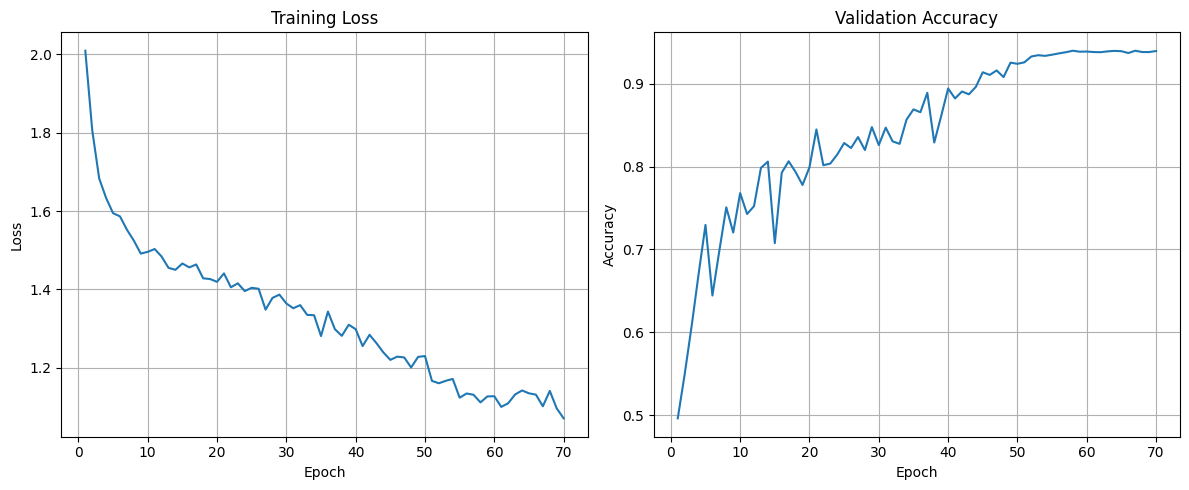

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


4. Modify the second network architecture by tuning the layer hyperparameters or adjusting the layer design to improve test accuracy while remaining within the four million parameter limit. Discuss your observations and the trade offs of the changes you make.

There are 3 types of modifications I have done to the model:
- Adjusting layer design
- Tuning layer hyperparameters
- Preprocessing input data
1. Adjusting layer design
I used a model that is similar to ResNet instead of traditional CNN to avoid gradient vanish. There are 3 stages of Residual Block, I find that to be a sweet spot because 2 has lower accuracy and 4 takes longer computational time. Within each block, I use 2 blocks of Conv -> ReLU -> BatchNorm -> Squeeze-Excitation block.
2. I intended to do the traditional 64 -> 128 -> 256 -> 512 filters for each subsequent block, but 512 at last layer has too many hyperparameters so I tuned it down to 278 which has slightly lower than 4M params.
3. For preprocessing, I used data augmentation, and a few more techniques to make the model less prone to overfitting.

## 2. Open discussion questions

1. How did hyperparameter tuning (learning rate, dropout, batch size) affect your model’s accuracy? Were there any unexpected results?

- For my model, I used a relatively high learning rate, and then used a Cosine Annealing LR scheduler to decrease it overtime. So it doesn't matter too much what the initial LR is. At the last quarter of the training process it tends to be at a sweet spot that the model learns the minor details the fastest.
- Dropout 0.05 or 0.45 has only a 0.5% difference in result.
- Batch size being 512 makes the CUDA ran out of memory (I think), so I decreased back to 256 and it ran normally.
- Number of epoch also doesn't affect the end results beyond certain point, as I used Cosine Annealing LR. So 50 or 200 yielded the same result.
- Converntionally, number of filters should be a multiple of 2. I used an odd multiplier like 1.4 and the model did significantly worse.
- And the most unexpected thing is label smoothing. I used it instead of Cross Entropy Loss function, and while it gave the same test accuracy at ~93-94%, the loss is much higher (0.5 instead of 0.01).

2. How did the constraint of keeping the model within 4 million parameters impact your design choices? Would a larger model necessarily perform better?

- As my model has a handicap layer of 278 filters, I believe that is the main reason why it couldn't perform better.
- A larger model does not necessarily mean it can perform better. There are also other factors such as image preprocessing, if the user does not perform correctly, it can lead to the model perform no better than random chance. (For example I once accidentally set all pixels to 0-1 instead of normalizing, making the whole training set black. The model then has 10% accuracy which is basically random guess)

3. How can deep learning models trained on datasets like CIFAR-10 be applied in real-world scenarios? Give an example.

- CIFAR-10 is not a good dataset for real world applications. There are better ones such as ImageNet or DINOv2, however this is a good starting point for AI students. It can be used in low-resolution camera for detecting objects in a student project.

4. Deep learning models for image recognition can have biases. What ethical concerns should be considered when deploying such models?

Surely bias training data leads to bias in predictions, and no dataset can perfectly represents the real world. There will be concerns about interpretability, privacy, responsibility, etc
- Interpretability: when a model makes certain prediction and cannot justify it, people tend to not believe it as much
- Privacy: data collection of images that were not supposed to be taken can be a debatable topic.
- Responsibilty: AI cannot go to jail, therefore someone might have to

5. What was the most interesting or challenging part of this assignment? If you had more time, what additional improvements would you make?

- Playing this AI game is like gambling, I let the model run and expect good results, and when I come back to it, the dopamine rush when I see an unexpected results hit like a truck.
Also this game is expensive, I need to have good GPUs to do enough trials and error so that I can learn something about it.
- I've had enough time with it, but if I had more time, I will try other models like DenseNet or transformer. 